In [ ]:
LOADING DATASET

import pandas as pd
import numpy as np
import cv2

# Load CSV file containing image paths and RLE-encoded masks
df = pd.read_csv('/content/sample_data/file/train.csv')

# Define a function to decode RLE-encoded masks
def rle_decode(rle_str, image_shape):
    mask = np.zeros(image_shape, dtype=np.uint8)
    pairs = np.array(rle_str.split(' '), dtype=np.int32).reshape(-1, 2)
    for start, length in pairs:
        start -= 1  # Convert to 0-based index
        mask[start:start+length] = 1
    return mask

base_dir = '/content/sample_data/train_images/'
# Load images and masks, and preprocess them
images = []
masks = []  #these have been obtained from rle
labels = []  #binary labels
img_masks=[]  #these are obtained from dividing the original image into 2 parts
for idx, row in df.iterrows():
    image_name = row['id']
    clabels = row['binary_pred'];
    image_path = base_dir + image_name
    rle_str = row['segmentation_pred']
    image_o = cv2.imread(image_path)
    image=image_o[:,:256]
    img_mask=image_o[:,256:]
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

    if rle_str == 'Healthy':
      mask = np.zeros(image.shape[:2], dtype=np.uint8)
    else:
      mask = rle_decode(rle_str, image.shape[:2])  # Decode RLE-encoded mask
    # Preprocess image and mask (e.g., resize, normalize)
    # Add preprocessed image and mask to lists
    labels.append(clabels);
    images.append(image)
    masks.append(mask)
    img_masks.append(img_mask)

# Convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)
img_masks = np.array(img_masks)

print('Dataset shape:', images.shape)
print('Dataset shape:', masks.shape)
print('Dataset shape:', labels.shape)
print('Dataset shape:', img_masks.shape)


Dataset shape: (894, 256, 256, 3)
Dataset shape: (894, 256, 256)
Dataset shape: (894,)
Dataset shape: (894, 256, 256)


# **IMPORTING LIBRARIES**

In [ ]:
#installing the libraries:

import pandas as pd
import numpy as np
from glob import glob
import glob2
from tqdm import tqdm
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
from joblib import Parallel, delayed
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf
import keras
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
import random as rn
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, Callback
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# import tensorflow.keras.applications.efficientnet as efn
from tensorflow.keras import Sequential
from keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D

from tensorflow import reduce_sum
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [ ]:
from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
#from keras.legacy import interfaces
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image

# **TEST-TRAIN SPLIT**

In [ ]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

#X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(images, img_masks, test_size=0.2, random_state=42)
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(images, labels, test_size=0.2, random_state=42)


# **DATA AUGMENTATION AND NORMALIZATION**

In [ ]:
import random

#https://www.kaggle.com/danofer/ranzcr-chexnet-starter
#https://www.tensorflow.org/tutorials/images/data_augmentation

def build_decoder(with_labels=True, target_size=(300, 300)):
    def decode(img):
        #file_bytes = tf.io.read_file(path)
        #img = tf.image.decode_png(file_bytes, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img

    def decode_with_labels(img, label):
        return decode(img), label

    return decode_with_labels if with_labels else decode

def build_augmenter(with_labels=True):
    def augment(img):
        number = random.randint(1,5)
        seed = (1, 5)
        if number == 1:
            img = tf.image.stateless_random_flip_left_right(img,seed)
            img = tf.image.stateless_random_contrast(img,0.2, 0.5,seed)
        if number == 2:
            img = tf.image.stateless_random_flip_up_down(img,seed)
            img = tf.image.stateless_random_brightness(img, 0.2,seed)
        if number == 3:
            img = tf.image.stateless_random_flip_left_right(img,seed)
            img = tf.image.stateless_random_saturation(img, 0.2, 0.5,seed)
        if number == 4:
            img = tf.image.stateless_random_flip_up_down(img,seed)
            img = tf.image.stateless_random_hue(img, 0.2,seed)
        if number == 5:
            img = tf.image.stateless_random_flip_left_right(img,seed)
            img = tf.image.adjust_gamma(img, 0.2)
        return img

    def augment_with_labels(img, label):
        return augment(img), label

    return augment_with_labels if with_labels else augment

def build_dataset(images, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024,cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    AUTO = tf.data.experimental.AUTOTUNE
    slices = images if labels is None else (images, labels)

    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)

    return dset

In [ ]:
#Building the decoder for building the Train and Valid Dataset:

decoder = build_decoder(with_labels=True, target_size=(256, 256))
print(decoder)

<function build_decoder.<locals>.decode_with_labels at 0x7ee322995bd0>


# **TRAIN AND VALIDATION DATASETS**

In [ ]:
dtrain = build_dataset(
    X_train_class, y_train_class, bsize=16, decode_fn=decoder,cache_dir='Kaggle/tf_cache'
)

dvalid = build_dataset(
    X_val_class, y_val_class, bsize=16,
    repeat=False, shuffle=False, augment=False, decode_fn=decoder,cache_dir='Kaggle/tf_cache'
)

print('Train Dataset : ',dtrain)
print('Valid Dataset : ',dvalid)

Train Dataset :  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Valid Dataset :  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# **THE CLASSIFICATION MODEL - DENSE NET**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Concatenate, GlobalAveragePooling2D

def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x1 = BatchNormalization()(x)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(4 * growth_rate, 1, padding='same', kernel_initializer='he_normal')(x1)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(growth_rate, 3, padding='same', kernel_initializer='he_normal')(x1)
        x = Concatenate()([x, x1])
    return x

def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(x.shape[-1] * reduction), 1, padding='same', kernel_initializer='he_normal')(x)
    x = AveragePooling2D(2, strides=2)(x)
    return x

def dense_net(input_shape, blocks=[6, 12, 24, 16], growth_rate=32, classes=1):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    for i, num_blocks in enumerate(blocks):
        x = dense_block(x, num_blocks, growth_rate)
        if i != len(blocks) - 1:
            x = transition_block(x, 0.5)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(classes, activation='sigmoid')(x)

    model = Model(inputs, outputs, name='DenseNet')
    return model

# Example usage:
input_shape = (256, 256, 3)
model = dense_net(input_shape)
model.summary()


Model: "DenseNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization[0

In [ ]:
model.inputs, model.outputs

([<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>],
 [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense')>])

In [ ]:
X_train_class.shape[0]

715

In [ ]:
BATCH_SIZE = 16
#total number of datapooints that should be passed through the network in individual epochs. This is used when we are generating data through augmentations
weighted_steps_per_epoch = X_train_class.shape[0] // BATCH_SIZE

#Callback for saving the weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'chexnet_model_new.h5', save_best_only=True, monitor='val_auc', mode='max',restore_best_weights=True)

#Callback for the ReduceLROnPlateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", patience=3, min_lr=1e-6, mode='max')

#Callback to stop training if the metric value doesnt change for 6 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', min_delta=0.0001, patience=6, mode='max',restore_best_weights=True)

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

#Adam optimizer
optim = tf.keras.optimizers.Adam(0.0001)

In [ ]:
#Compile the model:
model.compile(optimizer=optim,loss='binary_crossentropy',metrics=[METRICS])

In [ ]:
history = model.fit(
    dtrain,
    epochs=10, # training for smaller epochs at a time because kernel is getting disconnected very easily.
    verbose=1,
    callbacks=[checkpoint, lr_reducer,early_stop],
    steps_per_epoch=weighted_steps_per_epoch,
    validation_data=dvalid
)

Epoch 1/10
44/44 [==============================] - 112s 361ms/step - loss: 0.6531 - tp: 195.0000 - fp: 108.0000 - tn: 288.0000 - fn: 113.0000 - accuracy: 0.6861 - precision: 0.6436 - recall: 0.6331 - auc: 0.7649 - val_loss: 0.6031 - val_tp: 41.0000 - val_fp: 37.0000 - val_tn: 71.0000 - val_fn: 43.0000 - val_accuracy: 0.5833 - val_precision: 0.5256 - val_recall: 0.4881 - val_auc: 0.6433 - lr: 1.0000e-04
Epoch 2/10
44/44 [==============================] - 13s 298ms/step - loss: 0.4736 - tp: 227.0000 - fp: 83.0000 - tn: 309.0000 - fn: 85.0000 - accuracy: 0.7614 - precision: 0.7323 - recall: 0.7276 - auc: 0.8536 - val_loss: 0.6160 - val_tp: 53.0000 - val_fp: 40.0000 - val_tn: 68.0000 - val_fn: 31.0000 - val_accuracy: 0.6302 - val_precision: 0.5699 - val_recall: 0.6310 - val_auc: 0.7145 - lr: 1.0000e-04
Epoch 3/10
44/44 [==============================] - 14s 307ms/step - loss: 0.4735 - tp: 235.0000 - fp: 92.0000 - tn: 307.0000 - fn: 70.0000 - accuracy: 0.7699 - precision: 0.7187 - recall: 

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
auc = history.history['auc']
precision = history.history['precision']
recall = history.history['recall']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_auc = history.history['val_auc']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

In [ ]:
print("Metric Values after Training Next 28 Epochs : \n")
print('Train Accuracy : ', acc)
print('Train Loss : ', loss)
print('Train AUC : ', auc)
print('Train Precision : ', precision)
print('Train Recall : ', recall)
print('Train Val_Accuracy : ', val_acc)
print('Train Val_Loss : ', val_loss)
print('Train Val_Auc : ', val_auc)
print('Train Val_Precision : ', val_precision)
print('Train Val_Recall : ', val_recall)
print("==========================================")

Metric Values after Training Next 28 Epochs : 

Train Accuracy :  [0.6860795617103577, 0.7613636255264282, 0.7698863744735718, 0.8125, 0.8522727489471436, 0.8338068127632141, 0.8465909361839294, 0.8664772510528564, 0.8181818127632141, 0.8806818127632141]
Train Loss :  [0.6531417369842529, 0.47355014085769653, 0.47345301508903503, 0.4035961329936981, 0.3560880720615387, 0.41705599427223206, 0.35820716619491577, 0.31720107793807983, 0.389692097902298, 0.3216042220592499]
Train AUC :  [0.7649013996124268, 0.8536352515220642, 0.8592094779014587, 0.894914448261261, 0.9211857914924622, 0.8948929905891418, 0.9249765276908875, 0.937995970249176, 0.9058761596679688, 0.9371697306632996]
Train Precision :  [0.6435643434524536, 0.7322580814361572, 0.718654453754425, 0.7816091775894165, 0.8500000238418579, 0.7981651425361633, 0.8238636255264282, 0.8364779949188232, 0.7892976403236389, 0.8706624507904053]
Train Recall :  [0.6331169009208679, 0.7275640964508057, 0.7704917788505554, 0.8292682766914368

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score,accuracy_score

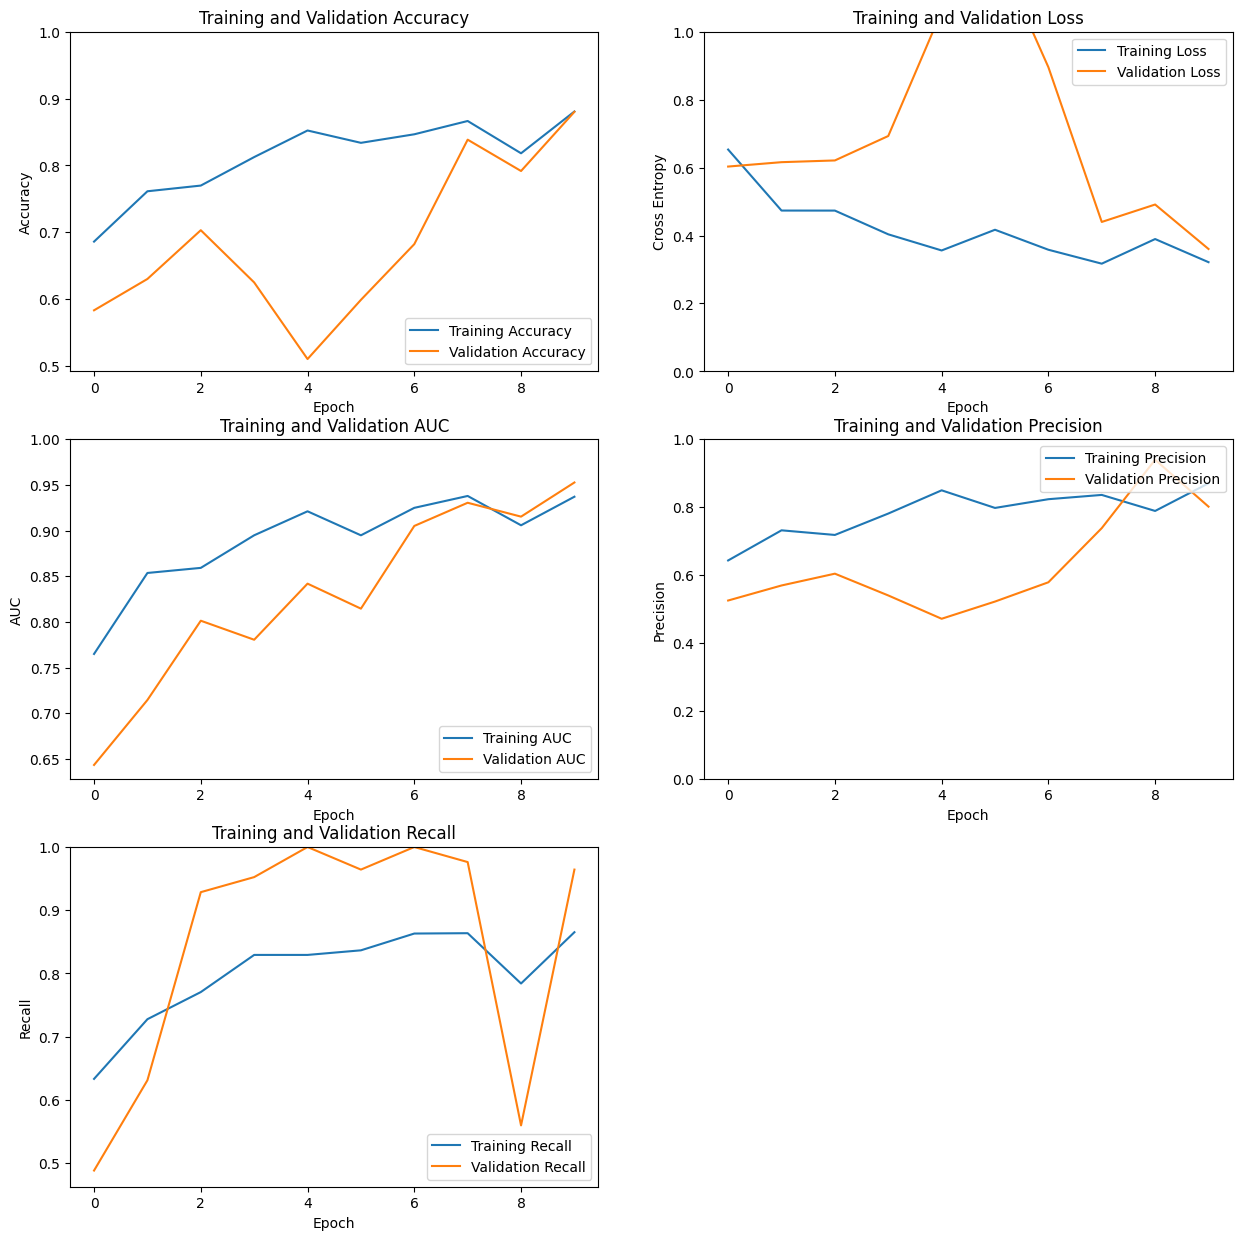

In [ ]:
#Plotting the metrics:

plt.figure(figsize=(15, 15))

#Plotting the Accuracy:
plt.subplot(3, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

#Plotting the Loss:
plt.subplot(3, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

#Plotting the AUC:
plt.subplot(3, 2, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')

#Plotting the Precision:
plt.subplot(3, 2, 4)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')

#Plotting the Recall:
plt.subplot(3, 2, 5)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')

#Showing all the graphs:
plt.show()

In [ ]:
test_decoder = build_decoder(with_labels=False, target_size=(256, 256))

train_features = build_dataset(
    X_train_class, bsize=BATCH_SIZE, repeat=False,
    shuffle=False, augment=False, cache=False,
    decode_fn=test_decoder
)

valid_features = build_dataset(
    X_val_class, bsize=BATCH_SIZE, repeat=False,
    shuffle=False, augment=False, cache=False,
    decode_fn=test_decoder
)

In [ ]:
train_features, valid_features

(<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>,
 <_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>)

# **TESTING**

In [ ]:
valid_predictions_baseline = model.predict(valid_features, batch_size=16)

12/12 [==============================] - 6s 273ms/step


In [ ]:
valid_baseline_results = model.evaluate(dvalid,batch_size=16, verbose=0)
val_precision = round((valid_baseline_results[6]),5)
val_recall = round((valid_baseline_results[7]),5)
val_loss = round((valid_baseline_results[0]),5)
val_auc = round((valid_baseline_results[8]),5)
print('METRIC VALUES FOR VALID DATASET : \n')
print('PRECISION : ', val_precision)
print('RECALL : ', val_recall)
print('LOSS : ', val_loss)
print('AUC : ', val_auc)

METRIC VALUES FOR VALID DATASET : 

PRECISION :  0.80198
RECALL :  0.96429
LOSS :  0.36045
AUC :  0.95277


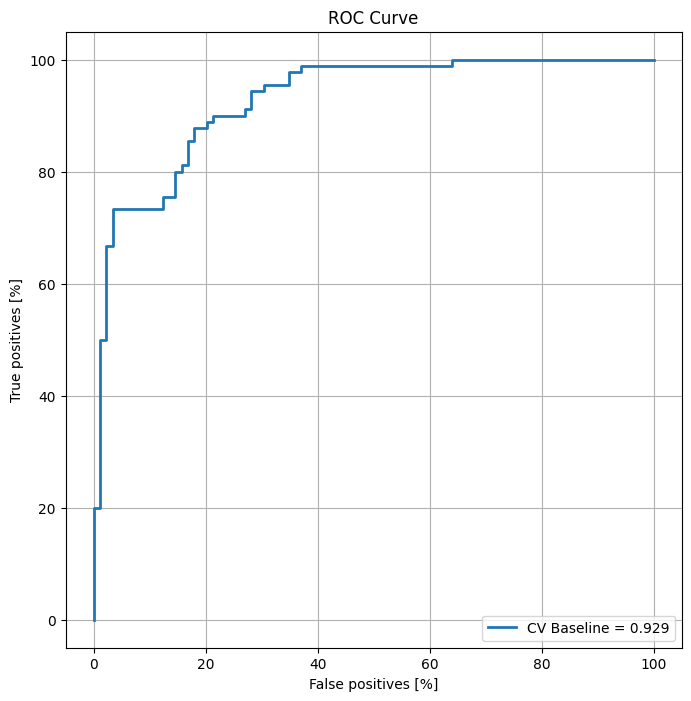

In [ ]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_roc(name, labels, predictions):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc = round(metrics.auc(fp, tp),3)

  plt.figure(figsize=(8, 8))
  plt.plot(100*fp, 100*tp, label=name+" = " +str(auc), linewidth=2)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  plt.title("ROC Curve")
  ax = plt.gca()
  ax.set_aspect('equal')

  #Plotting the ROC Curve on CV Dataset:
plot_roc("CV Baseline", y_val_class, valid_predictions_baseline)
plt.legend(loc='lower right')

# **TESTING DATA RESULTS**

In [ ]:
import pandas as pd
import numpy as np
import cv2

# Load CSV file containing image paths and RLE-encoded masks
df = pd.read_csv('/content/sample_data/file/test.csv')

# Define a function to decode RLE-encoded masks
def rle_decode(rle_str, image_shape):
    mask = np.zeros(image_shape, dtype=np.uint8)
    pairs = np.array(rle_str.split(' '), dtype=np.int32).reshape(-1, 2)
    for start, length in pairs:
        start -= 1  # Convert to 0-based index
        mask[start:start+length] = 1
    return mask

base_dir = '/content/sample_data/test_images/'
# Load images and masks, and preprocess them
test_images = []
for idx, row in df.iterrows():
    image_name = row['id']
    image_path = base_dir + image_name
    image = cv2.imread(image_path)
    # Preprocess image and mask (e.g., resize, normalize)
    # Add preprocessed image and mask to lists
    test_images.append(image)

# Convert lists to numpy arrays
test_images = np.array(test_images)

print('Dataset shape:', test_images.shape)


Dataset shape: (394, 256, 256, 3)


In [ ]:
test_decoder = build_decoder(with_labels=False, target_size=(256, 256))

dtest = build_dataset(
    test_images, bsize=BATCH_SIZE, repeat=False,
    shuffle=False, augment=False, cache=False,
    decode_fn=test_decoder
)

In [ ]:
dtest

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

# **STORING RESULTS IN CSV**

In [ ]:
test_df = pd.read_csv('/content/sample_data/file/test.csv')
test_df.head(2)

,id,binary_pred,segmentation_pred
0,Img_919.png,NaN,NaN
1,Img_920.png,NaN,NaN


In [ ]:
# Check if the columns exist before dropping
columns_to_drop = ['binary_pred', 'segmentation_pred']
existing_columns = test_df.columns.tolist()

columns_to_drop_existing = [col for col in columns_to_drop if col in existing_columns]

# Drop the columns
if columns_to_drop_existing:
    test_df = test_df.drop(columns=columns_to_drop_existing)
else:
    print("Columns to drop not found in the dataset.")

# Save the modified dataset
test_df.to_csv('modified_dataset.csv', index=False)


In [ ]:
probabilities = model.predict(dtest, verbose=1)
# Apply threshold
test_df['binary_pred'] = (probabilities > 0.5).astype(int)
test_df.to_csv('/content/sample_data/file/test_results.csv', index=False)
test_df.head(2)

25/25 [==============================] - 2s 69ms/step


,id,binary_pred
0,Img_919.png,0
1,Img_920.png,0


In [ ]:
test_df.head(5)

,id,binary_pred
0,Img_919.png,0
1,Img_920.png,0
2,Img_921.png,0
3,Img_922.png,1
4,Img_923.png,1
